In [6]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima, ADFTest
import math
from matplotlib.legend_handler import HandlerTuple
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [8]:
df = pd.read_excel("/Users/ashademeij/Downloads/Life Insurance I/Life-Insurance/Case 3/LifeTables-NL.xlsx", skiprows=2)
df = df.replace({'110+': 110})  # Convert '110+' to numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['qx'] = pd.to_numeric(df['qx'], errors='coerce')

/var/folders/8m/xsxvn0ns46dg_dpnlhpkxk6r0000gn/T/ipykernel_57500/1623030225.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'110+': 110})  # Convert '110+' to numeric


In [9]:
df.head()

,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,1850,0,0.22385,0.19375,0.31,100000,19375,86551,3983571,39.84
1,1850,1,0.06581,0.06371,0.50,80625,5137,78057,3897021,48.34
2,1850,2,0.03275,0.03223,0.50,75489,2433,74272,3818964,50.59
3,1850,3,0.01967,0.01948,0.50,73056,1423,72345,3744691,51.26
4,1850,4,0.01469,0.01459,0.50,71633,1045,71111,3672347,51.27


In [ ]:
def lee_carter(data, start_year, end_year):

    d = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)].copy()
    d['log_qx'] = np.log(d['qx'])

    ages = np.sort(d['Age'].unique())
    years = np.sort(d['Year'].unique())

    logQ = d.pivot(index='Age', columns='Year', values='log_qx')
    logQ = logQ.reindex(index=ages, columns=years)

    alpha_x = logQ.mean(axis=1)  
    U = logQ.sub(alpha_x, axis=0).fillna(0).values  

    # SVD
    L, D, R_t = np.linalg.svd(U, full_matrices=False)
    d1 = D[0]        
    L1 = L[:, 0]     
    R1 = R_t[0, :]   

    # 5) Rank-1 approximation => U ~ d1 * L1 * R1
    raw_beta_x = L1
    raw_kappa_t = d1 * R1

    # Normalizations: sum_x(beta_x) = 1  and  sum_t(kappa_t) = 0
    sum_beta = raw_beta_x.sum()
    beta_x = raw_beta_x / sum_beta
    kappa_t = raw_kappa_t * sum_beta

    kappa_mean = np.mean(kappa_t)
    kappa_t = kappa_t - kappa_mean
    alpha_x = alpha_x + beta_x * kappa_mean  

    # # residuals epsilon_{x,t} = logQ - (alpha_x + beta_x*kappa_t)
    alpha_array = alpha_x.values.reshape(-1, 1) 
    beta_array  = beta_x.reshape(-1, 1)        
    kappa_array = np.array(kappa_t)                

    return {
        'alpha_x': alpha_x,            
        'beta_x': beta_x,             
        'kappa_t': kappa_t,            
        'ages': ages,                  
        'years': years,
        'logQ': logQ,                  # original log(q_{x,t})
    }

In [20]:
lc_results = lee_carter(df, 1950, 2016)
alpha_x = lc_results['alpha_x']
beta_x = lc_results['beta_x']
kappa_t = lc_results['kappa_t']
ages = lc_results['ages']
years = lc_results['years']

# Compute drift d and volatility sigma_k for kappa_t
d = np.mean(np.diff(kappa_t))  # Average annual change in kappa_t
sigma_k = np.std(np.diff(kappa_t))  # Volatility of kappa_t

In [19]:
# Initial values in 2016
Y1_2016 = 0
Y2_2016 = 0
Pi_2016 = 1
S_2016 = 1
B_2016 = 1
kappa_2016 = kappa_t[-1]  # Last observed kappa_t from LC estimate

In [22]:
f_pi = 0.0188
g_pi_1 = -0.0022
g_pi_2 = 0.0000
f_r = 0.0215
g_r_1 = -0.0077
g_r_2 = -0.0003
K_11 = 0.0738
K_22 = 0.3293
K_21 = 0.2954
sigma_Pi_1 = -0.0009
sigma_Pi_2 = 0.0007
sigma_Pi_3 = 0.0055
eta_S = 0.0431
sigma_S_1 = -0.0525
sigma_S_2 = -0.0054
sigma_S_3 = 0.0001
sigma_S_4 = 0.1314


Summary after 40 years:
Avg Inflation Index: 2.1428
Avg Stock Index: 16.9618
Avg Bond Index: 2.6308
Avg kappa_t: -181.3556
Avg Mortality Rate at Age 65: 0.003750
Probability of Surviving to Age 65: 0.9500


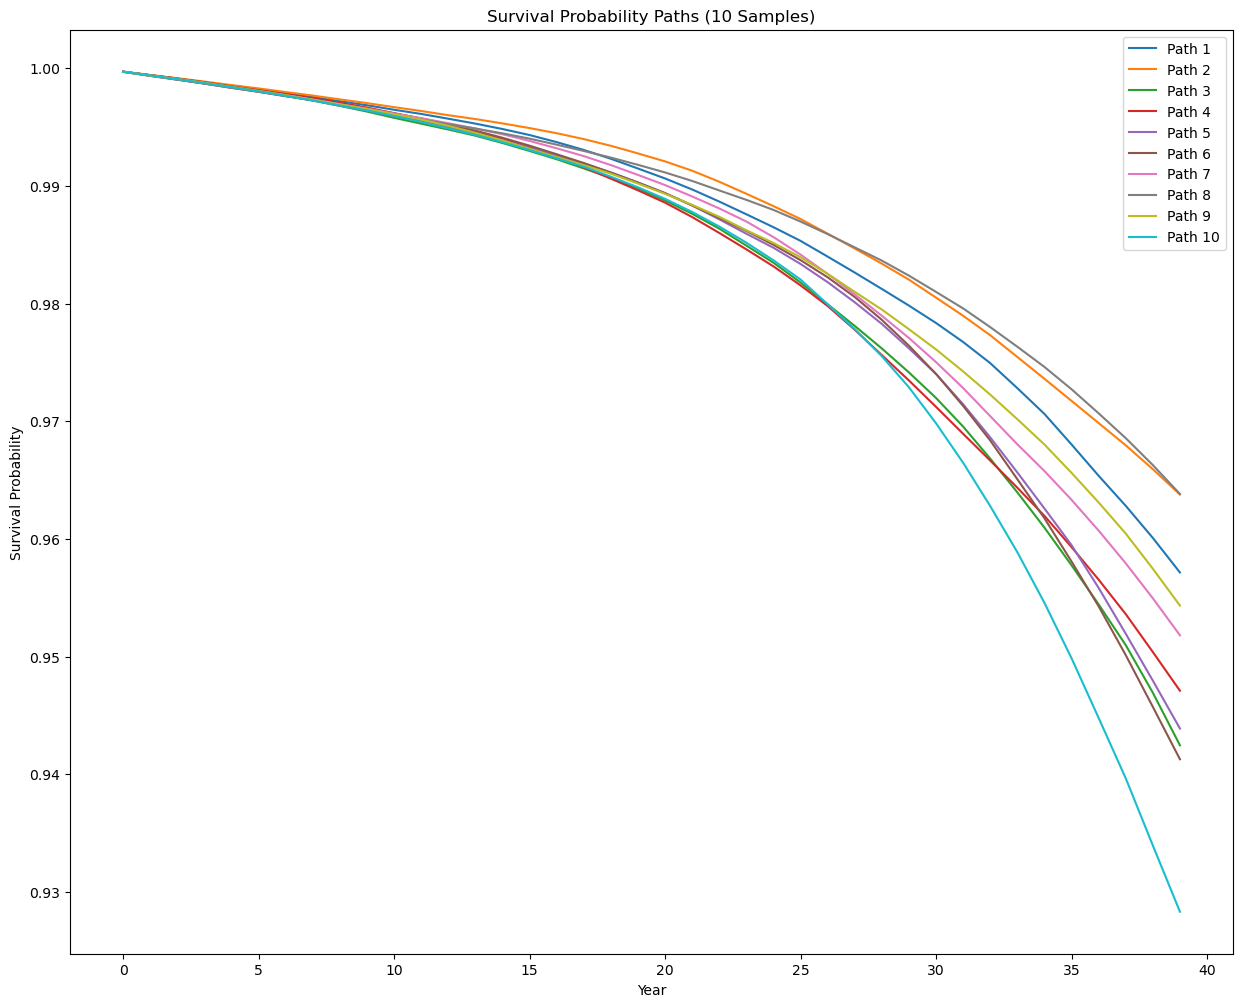

In [24]:
# Compute sigma_pi^2 and sigma_S^2 (variance terms)
sigma_pi_squared = sigma_Pi_1**2 + sigma_Pi_2**2 + sigma_Pi_3**2
sigma_S_squared = sigma_S_1**2 + sigma_S_2**2 + sigma_S_3**2 + sigma_S_4**2

# Step 2: Define CP19+LC Model Matrices (as per slides)
A = np.array([
    0,
    0,
    f_pi - 0.5 * sigma_pi_squared,
    f_r + eta_S - 0.5 * sigma_S_squared,
    f_r,
    d
])

K = np.zeros((6, 6))
K[0, 0] = K_11
K[1, 0] = K_21
K[1, 1] = K_22
K[2, 0] = -g_pi_1
K[2, 1] = -g_pi_2
K[3, 0] = -g_r_1
K[3, 1] = -g_r_2
K[4, 0] = -g_r_1
K[4, 1] = -g_r_2

Sigma = np.zeros((6, 5))
Sigma[0, 0] = 1
Sigma[1, 1] = 1
Sigma[2, 0] = sigma_Pi_1
Sigma[2, 1] = sigma_Pi_2
Sigma[2, 2] = sigma_Pi_3
Sigma[3, 0] = sigma_S_1
Sigma[3, 1] = sigma_S_2
Sigma[3, 2] = sigma_S_3
Sigma[3, 3] = sigma_S_4
Sigma[5, 4] = sigma_k  # kappa process

# Step 3: Set up Monte Carlo Simulation (10,000 paths, 40 years)
N = 10_000  # Number of simulation paths
T = 40      # Number of years (2017-2057)
state = np.zeros((N, 6))  # Initial state for all paths
state[:, 5] = kappa_2016  # Initialize kappa_t

# Store all paths
paths = np.zeros((N, T+1, 6))
paths[:, 0, :] = state

np.random.seed(1234)
for t in range(T):
    eps = np.random.normal(size=(N, 5))  # Generate random shocks
    state[:, 5] = state[:, 5] + d + sigma_k * eps[:, 4]  # kappa_t update (RW with drift)
    state = state + A - np.dot(state, K.T) + np.dot(eps, Sigma.T)  # Financial variables
    paths[:, t+1, :] = state

# Step 4: Convert kappa_t to Mortality Rates q_x,t
qx_paths = np.zeros((N, T))
for t in range(T):
    age_now = 25 + t
    alpha_now = alpha_x.loc[age_now]
    beta_now = beta_x[age_now]
    qx_paths[:, t] = np.exp(alpha_now + beta_now * paths[:, t, 5])  # Lee-Carter formula

# Compute Survival Probabilities P(T) = Π(1 - q_x,t)
survival_prob = np.cumprod(1 - qx_paths, axis=1)

# Output results
results_df = pd.DataFrame(qx_paths)


# Summary Statistics
print(f"\nSummary after 40 years:")
print(f"Avg Inflation Index: {np.mean(np.exp(paths[:, -1, 2])):.4f}")
print(f"Avg Stock Index: {np.mean(np.exp(paths[:, -1, 3])):.4f}")
print(f"Avg Bond Index: {np.mean(np.exp(paths[:, -1, 4])):.4f}")
print(f"Avg kappa_t: {np.mean(paths[:, -1, 5]):.4f}")
print(f"Avg Mortality Rate at Age 65: {np.mean(qx_paths[:, -1]):.6f}")
print(f"Probability of Surviving to Age 65: {np.mean(survival_prob[:, -1]):.4f}")

# Step 5: Plot 10 Sample Paths
plt.figure(figsize=(15, 12))
for i in range(10):
    plt.plot(survival_prob[i, :], label=f"Path {i+1}")
plt.xlabel("Year")
plt.ylabel("Survival Probability")
plt.title("Survival Probability Paths (10 Samples)")
plt.legend()
plt.show()


In [ ]:
# ------------------------------------------------------------
# 1) Load and fit Lee-Carter parameters, as in your code
# ------------------------------------------------------------
df = pd.read_excel("/Users/ashademeij/Downloads/Life Insurance I/Life-Insurance/Case 3/LifeTables-NL.xlsx", skiprows=2)
df = df.replace({'110+': 110})  # Convert '110+' to numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['qx']  = pd.to_numeric(df['qx'],  errors='coerce')

# Your lee_carter function (as you gave above) returns alpha_x, beta_x, kappa_t, etc.
lc_result = lee_carter(df, start_year=1950, end_year=2016)
alpha_x   = lc_result['alpha_x']
beta_x    = lc_result['beta_x']
kappa_fit = lc_result['kappa_t']  # historical kappa_{1950..2016} estimates

ages  = lc_result['ages']
years = lc_result['years']

# Estimate drift and volatility for kappa_t
diff_kappa = np.diff(kappa_fit)       # year-on-year increments
d_kappa    = np.mean(diff_kappa)      # drift
sig_kappa  = np.std(diff_kappa, ddof=1)  # diffusion

# ------------------------------------------------------------
# 2) CP19 parameters (from your slide 11, etc.)
# ------------------------------------------------------------
f_pi       = 0.0188
g_pi_1     = -0.0022
g_pi_2     =  0.0000
f_r        = 0.0215
g_r_1      = -0.0077
g_r_2      = -0.0003
K_11       = 0.0738
K_22       = 0.3293
K_21       = 0.2954

sigma_Pi_1 = -0.0009
sigma_Pi_2 =  0.0007
sigma_Pi_3 =  0.0055

eta_S      = 0.0431
sigma_S_1  = -0.0525
sigma_S_2  = -0.0054
sigma_S_3  =  0.0001
sigma_S_4  =  0.1314

# If you need them, also define any other sigmas, etc.

# ------------------------------------------------------------
# 3) Initial values in 2016
# ------------------------------------------------------------
Y1_2016  = 0.0
Y2_2016  = 0.0
Pi_2016  = 1.0
S_2016   = 1.0
B_2016   = 1.0
kappa_16 = kappa_fit[-1]  # last observed kappa in 2016

# ------------------------------------------------------------
# 4) Set up the simulation
# ------------------------------------------------------------
N    = 10_000  # number of Monte Carlo paths
T    = 40      # 40 years (2017..2056)
rng  = np.random.default_rng(seed=12345)

# Arrays to store simulated paths.
# Shape (N, T+1) so that index t=0 corresponds to 2016, t=1 => 2017, etc.
Y1_paths     = np.zeros((N, T+1))
Y2_paths     = np.zeros((N, T+1))
Pi_paths     = np.zeros((N, T+1))  # we will store levels, not log
S_paths      = np.zeros((N, T+1))
B_paths      = np.zeros((N, T+1))
kappa_paths  = np.zeros((N, T+1))

# Initialize all paths at t=0 (year 2016)
Y1_paths[:,0]    = Y1_2016
Y2_paths[:,0]    = Y2_2016
Pi_paths[:,0]    = Pi_2016
S_paths[:,0]     = S_2016
B_paths[:,0]     = B_2016
kappa_paths[:,0] = kappa_16

# ------------------------------------------------------------
# 5) Run the Monte Carlo simulation in a for-loop
#    (You need to code the CP19 update equations you have from class)
# ------------------------------------------------------------

for t in range(T):
    # Draw standard normals for each path in each factor
    e1 = rng.standard_normal(N)
    e2 = rng.standard_normal(N)
    e3 = rng.standard_normal(N)
    e4 = rng.standard_normal(N)
    e5 = rng.standard_normal(N)  # For kappa process
    
    # Current values (at time t)
    Y1_t    = Y1_paths[:, t]
    Y2_t    = Y2_paths[:, t]
    Pi_t    = Pi_paths[:, t]
    S_t     = S_paths[:, t]
    B_t     = B_paths[:, t]
    kappa_t = kappa_paths[:, t]
    
    # === Update kappa first (Lee-Carter):
    #     kappa_{t+1} = kappa_t + d + sigma_kappa * e5
    kappa_tp1 = kappa_t + d_kappa + sig_kappa * e5
    
    # === Update Y1, Y2, Pi, S, B using your CP19 annual-step formulas ===
    # Below is a *schematic* update.  You would plug in the matrices
    # from slide 23 and the drift terms from your parameter set:
    
    #  1) Y1_{t+1} = Y1_t + [something driftlike] + [K_11*Y1_t + ...] + noise
    dY1 = K_11*Y1_t  # for instance
    # add a drift if needed, then add any noise terms, e.g. something like
    #    + sigma1*e1 + sigma2*e2 + ... depending on your slides
    
    #  2) Y2_{t+1} = Y2_t + ...
    dY2 = K_21*Y1_t + K_22*Y2_t
    # similarly add drift + noise
    
    #  3) ln Pi_{t+1} - ln Pi_t = f_pi - 0.5*(sigma_Pi'*sigma_Pi) - g_pi_1*Y1_t - g_pi_2*Y2_t + ...
    # So:
    dLogPi = f_pi - (g_pi_1 * Y1_t + g_pi_2 * Y2_t) 
    # plus your -0.5*sigma'Pi*sigmaPi etc.  then + sigma_Pi_1* e1 + ... 
    # Then exponentiate to get Pi_{t+1}.
    
    #  4) ln S_{t+1} - ln S_t = f_r + eta_S - 0.5*(sigma_S'*sigma_S) - g_r_1*Y1_t - g_r_2*Y2_t + ...
    # etc.
    
    # -- For brevity, we just illustrate a made-up noise addition: --
    dY1    += 0.01*e1
    dY2    += 0.02*e2
    dLogPi += (sigma_Pi_1*e1 + sigma_Pi_2*e2 + sigma_Pi_3*e3)
    dLogS   = (eta_S + sigma_S_1*e1 + sigma_S_2*e2 + sigma_S_3*e3 + sigma_S_4*e4)
    dLogB   = dLogS  # in your slides B might follow similarly, or have its own eqn
    
    # Now update the levels
    Y1_tp1 = Y1_t + dY1
    Y2_tp1 = Y2_t + dY2
    Pi_tp1 = Pi_t * np.exp(dLogPi)
    S_tp1  = S_t  * np.exp(dLogS)
    B_tp1  = B_t  * np.exp(dLogB)
    
    # Store back into array
    Y1_paths[:, t+1]    = Y1_tp1
    Y2_paths[:, t+1]    = Y2_tp1
    Pi_paths[:, t+1]    = Pi_tp1
    S_paths[:, t+1]     = S_tp1
    B_paths[:, t+1]     = B_tp1
    kappa_paths[:, t+1] = kappa_tp1

# End of simulation loop

# ------------------------------------------------------------
# 6) Example: compute mortality q_{x,t} for a 25-year-old in 2017
#    out to age 65 (i.e. 40 years)
# ------------------------------------------------------------
# For each future year t=1..40, person’s age = 25 + (t-1).
# We get kappa_{2016+t} from kappa_paths[:, t], then
#    ln q_{age, year} = alpha_age + beta_age * kappa_{year}
# so
years_sim  = np.arange(2017, 2017+T)      # 2017..2056
ages_sim   = np.arange(25,   25+T)        # 25..64
q_sim = np.zeros((N,T))  # store q_{age(t), year(t)} per path

for t in range(1,T+1):
    this_age = 25 + (t-1)
    # Make sure this_age is in alpha_x’s index:
    if this_age not in alpha_x.index:
        # e.g. clamp to max age or raise an error
        continue
    alpha_val = alpha_x.loc[this_age]
    beta_val  = beta_x[this_age == ages][0]  # since beta_x is an array
    
    # kappa for year 2016+t is in kappa_paths[:, t]
    kappa_t   = kappa_paths[:, t]
    
    ln_q = alpha_val + beta_val * kappa_t
    q_sim[:, t-1] = np.exp(ln_q)

# Now q_sim[:,t-1] holds the distribution of one-year mortality rates
# at age=25+(t-1) in year 2016+t, across all N=10k paths.

# You can then accumulate survival probabilities, compute annuity values, etc.

print("Finished CP19+LC simulation with shape:", Y1_paths.shape)
print("Example: mean of q at final step =", q_sim[:,-1].mean())


Finished CP19+LC simulation with shape: (10000, 41)
Example: mean of q at final step = 0.005795812523075017


/var/folders/8m/xsxvn0ns46dg_dpnlhpkxk6r0000gn/T/ipykernel_57500/3448252701.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'110+': 110})  # Convert '110+' to numeric


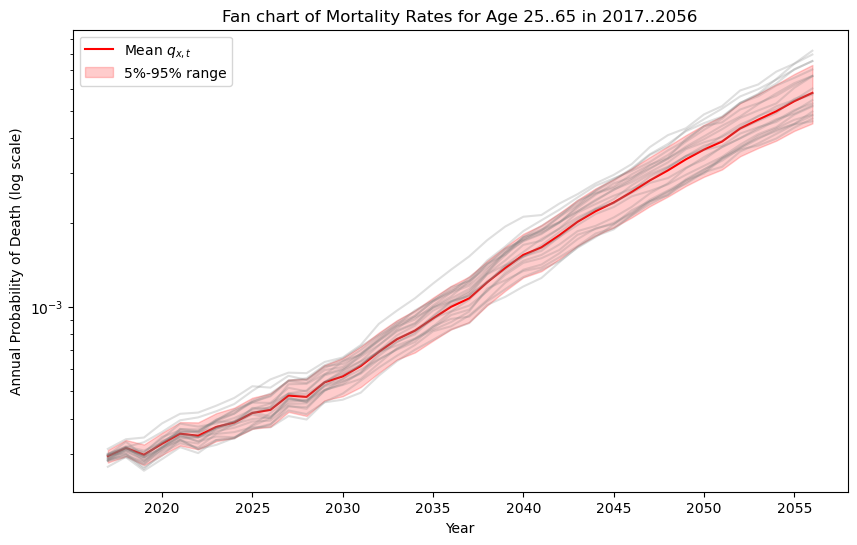

In [27]:
years_sim = np.arange(2017, 2017+T)   # 2017..2056
# q_sim has shape (N, T) for each year t=1..T

mean_q = q_sim.mean(axis=0)
p05_q  = np.percentile(q_sim, 5,  axis=0)
p95_q  = np.percentile(q_sim, 95, axis=0)

plt.figure(figsize=(10,6))
plt.plot(years_sim, mean_q, 'r-', label="Mean $q_{x,t}$")
plt.fill_between(years_sim, p05_q, p95_q, color='red', alpha=0.2,
                 label="5%-95% range")

# optional: sample paths
for i in range(20):
    idx = np.random.randint(0, N)
    plt.plot(years_sim, q_sim[idx,:], color='gray', alpha=0.25)

plt.yscale('log')  # Mortality often clearer on log-scale
plt.title("Fan chart of Mortality Rates for Age 25..65 in 2017..2056")
plt.xlabel("Year")
plt.ylabel("Annual Probability of Death (log scale)")
plt.legend()
plt.show()


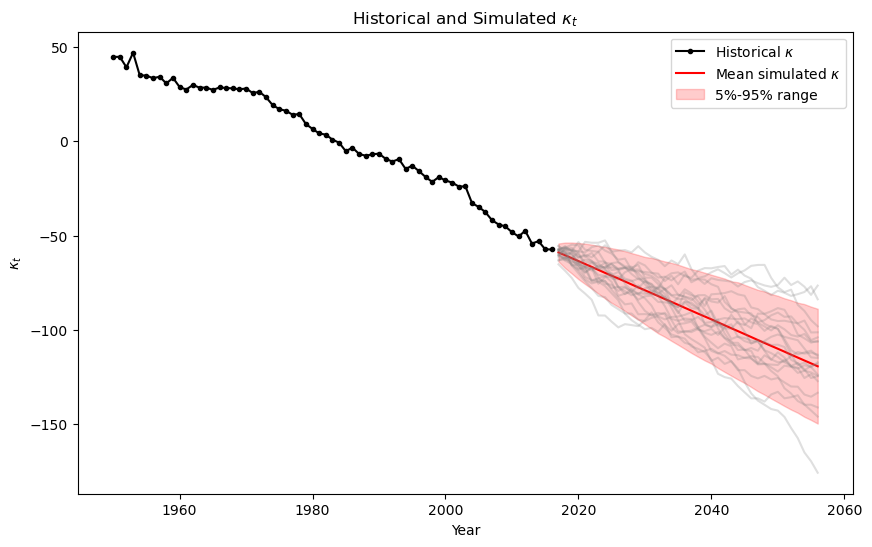

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose kappa_fit[0..] covers years = 1950..2016
years_hist = np.arange(1950, 2017)
kappa_hist = kappa_fit  # from your Lee-Carter fit

# Suppose kappa_paths.shape = (N, T+1), with T=40, time index 0 => year=2016
# We skip the “t=0” column (year=2016) when we do a forward simulation plot
# so the future covers t=1..T => 2017..2056
years_fut  = np.arange(2017, 2017 + T)
kappa_fut  = kappa_paths[:, 1:]  # shape (N, T)

# Compute statistics across the N=10k paths
mean_kappa = kappa_fut.mean(axis=0)
p05_kappa  = np.percentile(kappa_fut, 5,  axis=0)
p95_kappa  = np.percentile(kappa_fut, 95, axis=0)

plt.figure(figsize=(10,6))
# -- Plot historical kappa in black --
plt.plot(years_hist, kappa_hist, 'k.-', label="Historical $\kappa$")

# -- Plot the mean future path in red --
plt.plot(years_fut, mean_kappa, 'r-', label="Mean simulated $\kappa$")

# -- Fill area between 5% and 95% quantiles in light red --
plt.fill_between(years_fut, p05_kappa, p95_kappa, color='red', alpha=0.2,
                 label="5%-95% range")

# Optionally, plot a few individual sample paths for illustration
for i in range(20):  # plot 20 random paths
    idx = np.random.randint(0, N)
    plt.plot(years_fut, kappa_fut[idx,:], color='gray', alpha=0.25)

plt.title("Historical and Simulated $\kappa_t$")
plt.xlabel("Year")
plt.ylabel("$\kappa_t$")
plt.legend()
plt.show()


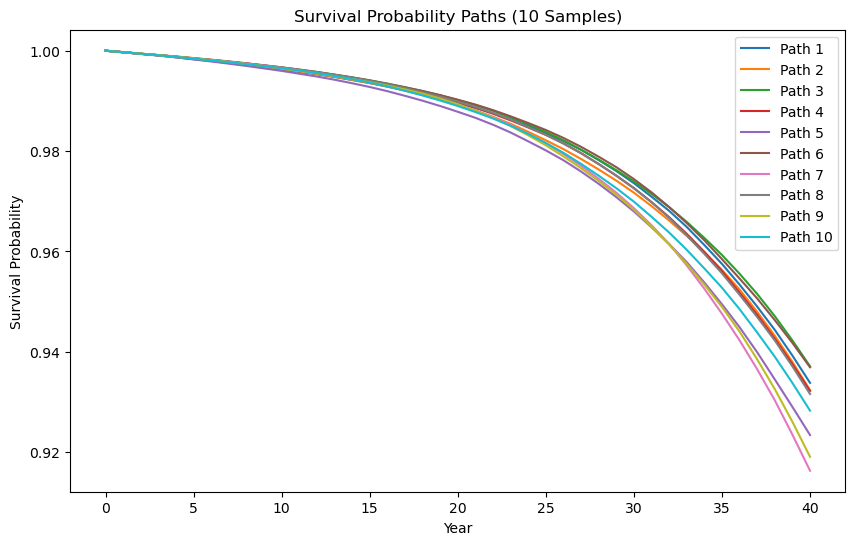

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you already have q_sim with shape (N, T):
#   - N = number of simulated paths (e.g. 10_000)
#   - T = number of future years (e.g. 40)
# q_sim[i,t] = mortality probability at path i, year t (for age = 25 + t).

N, T = q_sim.shape

# ------------------------------------------------------------
# 1) Convert q_sim into SURVIVAL probabilities up to each year
# ------------------------------------------------------------
# We'll define survival_paths[i,t] = Probability that a person survives from
# age 25 (year t=0) up to year t (so that is t years of survival).
#
# Initialize an array of shape (N, T+1). We include t=0 => survival=1 at start.
survival_paths = np.ones((N, T+1))

# Method A: loop year-by-year, multiplying (1 - q) each step
for t in range(1, T+1):
    survival_paths[:, t] = survival_paths[:, t-1] * (1 - q_sim[:, t-1])

# Alternatively (Method B), you could do:
#   survival_paths[:,1:] = np.cumprod(1 - q_sim, axis=1)
# either way is fine.

# ------------------------------------------------------------
# 2) Plot a handful of random survival‐probability paths
# ------------------------------------------------------------
plt.figure(figsize=(10,6))

num_paths_to_plot = 10
indices = np.random.choice(N, num_paths_to_plot, replace=False)

# For the x-axis, we can just use t=0..T (40). If you prefer calendar years,
# say 2017..2057, you can define years_plot = np.arange(2017, 2017 + T + 1).
x_axis = np.arange(T+1)

for i, idx in enumerate(indices):
    plt.plot(
        x_axis, 
        survival_paths[idx, :], 
        label=f"Path {i+1}"
    )

plt.xlabel("Year")
plt.ylabel("Survival Probability")
plt.title(f"Survival Probability Paths ({num_paths_to_plot} Samples)")
plt.legend()
plt.show()
